In [2]:
from neuron import h, load_mechanisms
from netpyne import specs, sim
import matplotlib.pyplot as plt
import os
import numpy as np
import random
import pandas as pd
from numpy.random import default_rng

h.load_file("stdrun.hoc")

cwd = os.getcwd()
output_dir = os.path.join(cwd, 'output')
data_dir = os.path.join(output_dir, 'data')
top_dir = os.path.dirname(cwd)
mod_dir = f'{top_dir}/mod'
load_mechanisms(mod_dir)

# TODO: run with 10 cells and see whats the biggest time step and shortest 
# simulation time to get same info to run quickly
n_cells = 10

stim_delay = 100
stim_dur = 1000
sim_dur = stim_dur + stim_delay*2

dt = 0.01

# 1200 dur, 0.01 dt -> time = 11 m, memory = 33 Gb

sim_flag = f'{dt}_{sim_dur}ms'

cfg = specs.SimConfig()	
cfg.duration = sim_dur				                 
cfg.dt = dt								                # Internal integration timestep to use
cfg.verbose = True							                # Show detailed messages
cfg.recordCells = ['all']
cfg.recordTraces = {'V_soma': {'sec': 'soma', 'loc': 0.5, 'var': 'v'}}
cfg.recordStep = dt
# cfg.recordStim = True
# cfg.filename = os.path.join(sim_dir, f'{sim_label}-DCN') 	# Set file output name
cfg.savePickle = False
# cfg.analysis['plotTraces'] = {'include': ['all'], 'saveFig': False, 'showFig': False}  # Plot recorded traces for this list of cells
# cfg.analysis['recordTraces'] = 
# cfg.analysis['plotSpikeFreq'] = {'include': ['all'], 'saveFig': True, 'showFig': True}
cfg.hParams['celsius'] = 34.0 
cfg.hParams['v_init'] = -60

netParams = specs.NetParams()

IzhCell = {'secs': {}}
IzhCell['secs']['soma'] = {'geom': {}, 'pointps': {}}                        # soma params dict
IzhCell['secs']['soma']['geom'] = {'diam': 50, 'L': 50, 'cm': 1}    # soma geometry, cm = 31.831
IzhCell['secs']['soma']['pointps']['Izhi'] = {                               # soma Izhikevich properties
    'mod':'Izhi2007b',
    'C':1,
    'k': 0.7,
    'vr':-60,
    'vt':-40,
    'vpeak':35,
    'a':0.03,
    'b':-2,
    'c':-50,
    'd':100,
    'celltype':1}
# IzhCell['secs']['soma']['threshold'] = -20
netParams.cellParams['IzhCell'] = IzhCell 

cell_types = ['P', 'I2']  #['P', 'I2', 'W', 'AN']
# record_cells = [(f'{cell_type}_pop', n_cells) for cell_type in cell_types]

pop_labels_nums = {cell_type: n_cells for cell_type in cell_types}

for pop_label, pop_num in pop_labels_nums.items():
    netParams.popParams[f'{pop_label}_pop'] = {'cellType': 'IzhCell',
                                                'numCells': pop_num}


nsa_freq = 80

e_syn_weight = 0.2

netParams.popParams[f'vecstim_NSA'] = {
            'cellModel': 'VecStim',
            'numCells': n_cells,  # int(len(syn_secs)/4),
            'spikePattern': {'type': 'poisson',
                            'start': stim_delay,
                            'stop': stim_dur+stim_delay,
                            'frequency': nsa_freq}  #  np.random.randint(params.spk_freq_lb, params.spk_freq_ub, 1)[0]}
        }

netParams.connParams[f'vecstim_NSA->P'] = {
    'preConds': {'pop': f'vecstim_NSA'},
    'postConds': {'pop': 'P_pop'},
    'sec': 'soma',
    'synsPerConn': 1,
    'synMech': 'exc',
    'weight': e_syn_weight,  # 
    # 'synMechWeightFactor': [0.5,0.5],
    'delay': 'defaultDelay + dist_2D/propVelocity',
    'connList': [[i,i] for i in range(n_cells)]
    }


cell_ids = {'ANF': [i for i in range(n_cells)],
            'I2': [i for i in range(n_cells)],
            'P': [i for i in range(n_cells)]}

num_octaves = 4

octave_scale = 0.25
bw_octs = {'ANF': 0.4, 'I2': 0.6}
bw_nums = {'ANF': int(bw_octs['ANF'] / (num_octaves/n_cells)),
           'I2': int(bw_octs['I2'] / (num_octaves/n_cells))}
n_scales = {'ANF': 0.6,
            'I2': 0.175}
ns = {'ANF': int(np.floor(n_scales['ANF']*bw_nums['ANF'])), 
      'I2': int(np.floor(n_scales['I2']*bw_nums['I2']))}

conns_list = {'ANF_I2': [],
              'ANF_P': [],
              'I2_P': []}


for conn in conns_list.keys():

    source = conn.split('_')[0]
    source_ids = cell_ids[source]

    target = conn.split('_')[1]
    target_ids = cell_ids[target]

    bw = bw_nums[source]
    if bw == 1: bw += 1
    bw_split = bw//2

    conn_list = []
    
    for target_id in target_ids:

        n_source = ns[source]
        if n_source == 0: n_source += 1

        lb = target_id - bw_split
        if lb < 0: lb = 0
        ub = target_id + bw_split+1

        source_pool = source_ids[lb:ub]

        # if n_source > bw/len(source_pool):
        n_source *= (len(source_pool)/bw)

        source_rand = random.sample(source_pool, int(np.floor(n_source)))

        conn_list.extend([[i, target_id] for i in source_rand])
    
    conns_list[conn] = conn_list


rng = default_rng()

rand_is = rng.choice(n_cells, size=n_cells, replace=False)
if n_cells == 1:
    anf_freqs_orig = [40]
else:
    anf_freqs_orig = [0 for i in range(n_cells)]

for j, rand_i in enumerate(rand_is):

    if j < n_cells//2:
        anf_freqs_orig[rand_i] = 0
    else:
        anf_freqs_orig[rand_i] = np.random.uniform(20, 40)

e_tau = 0.2
i_tau = 3
netParams.synMechParams['exc'] = {'mod': 'ExpSyn', 'tau': e_tau, 'e': 10}
netParams.synMechParams['inh'] = {'mod': 'ExpSyn', 'tau': i_tau, 'e': -70}

# num_spikes = {}

i_weights = [0.5]  #, 1, 1.5, 2]
bfs = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
bf_scale = 0.2
middle_is = [i for i in range(n_cells)]

weights_label = f'{i_weights[0]}_{i_weights[-1]}' if len(i_weights) > 1 else f'{i_weights[0]}'
sim_label = f'Ix{weights_label}-{n_cells}cells-{sim_flag}'

num_spikes_path = os.path.join(data_dir, f'{sim_label}-num_spikes.npy')
if os.path.exists(num_spikes_path):
    num_spikes = np.load(num_spikes_path, allow_pickle=True).item()
else:
    num_spikes = {}

fig_dir = os.path.join(output_dir, sim_label)
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)


for i_weight in i_weights:

    if i_weight not in num_spikes.keys():
        num_spikes[i_weight] = {}

    for bf in bfs:

        for middle_i in middle_is:
        
            anf_freqs = anf_freqs_orig[:]

            if bf not in num_spikes[i_weight].keys():
                num_spikes[i_weight][bf] = {}

            lb = middle_i - 2
            if lb < 0: lb = 0
            ub = middle_i + 3
            input_cells = cell_ids['P'][lb:ub]

            input_scales = [1 - bf_scale*np.abs(cell_i-middle_i) for cell_i in range(n_cells) if np.abs(cell_i-middle_i) <= 2]

            inputs = {input_cell: bf*input_scale for input_cell, input_scale in zip(input_cells, input_scales)} 

            for i, anf_freq in enumerate(anf_freqs):
                
                if i in inputs.keys():
                    anf_freqs[i] += inputs[i]

            print(anf_freqs)

            for i, anf_freq in enumerate(anf_freqs):

                netParams.popParams[f'vecstim_ANF{i}'] = {
                    'cellModel': 'VecStim',
                    'numCells': 1,  # int(len(syn_secs)/4),
                    'spikePattern': {'type': 'poisson',
                                    'start': stim_delay,
                                    'stop': stim_dur+stim_delay,
                                    'frequency': anf_freq}  #  np.random.randint(params.spk_freq_lb, params.spk_freq_ub, 1)[0]}
                }

                for cell_type in cell_types:

                    cell_conns = [conn for conn in conns_list[f'ANF_{cell_type}'] if conn[0] == i]

                    netParams.connParams[f'vecstim_ANF{i}->{cell_type}'] = {
                        'preConds': {'pop': f'vecstim_ANF{i}'},
                        'postConds': {'pop': f'{cell_type}_pop'},
                        'sec': 'soma',
                        'synsPerConn': 1,
                        'synMech': 'exc',
                        'weight': e_syn_weight,  # 
                        # 'synMechWeightFactor': [0.5,0.5],
                        'delay': 'defaultDelay + dist_2D/propVelocity',
                        'connList': [[0, cell_conn[1]] for cell_conn in cell_conns]  # [[0,i] for i in range(n_cells)]
                    }


            # i_weight = 0.5
            netParams.connParams['I2->P'] = {
                'preConds': {'pop': 'I2_pop'},
                'postConds': {'pop': 'P_pop'},
                'synsPerConn': 1,
                'synMech': 'inh',
                'weight': i_weight,
                # 'probability': 1.0
                'connList': conns_list['I2_P']
            }

temp = 5

Mechanisms already loaded from path: /home/kedoxey/DCN_model/mod.  Aborting.
[23.67634664140234, 29.852003977081257, 20.356972504983418, 0, 0, 37.39811897249178, 0, 35.921861207573826, 0, 0]
[23.67634664140234, 29.852003977081257, 20.356972504983418, 0.0, 0, 37.39811897249178, 0, 35.921861207573826, 0, 0]
[23.67634664140234, 29.852003977081257, 20.356972504983418, 0.0, 0.0, 37.39811897249178, 0, 35.921861207573826, 0, 0]
[23.67634664140234, 29.852003977081257, 20.356972504983418, 0.0, 0.0, 37.39811897249178, 0, 35.921861207573826, 0, 0]
[23.67634664140234, 29.852003977081257, 20.356972504983418, 0.0, 0.0, 37.39811897249178, 0.0, 35.921861207573826, 0, 0]
[23.67634664140234, 29.852003977081257, 20.356972504983418, 0.0, 0.0, 37.39811897249178, 0.0, 35.921861207573826, 0, 0]
[23.67634664140234, 29.852003977081257, 20.356972504983418, 0, 0.0, 37.39811897249178, 0.0, 35.921861207573826, 0.0, 0]
[23.67634664140234, 29.852003977081257, 20.356972504983418, 0, 0, 37.39811897249178, 0.0, 35.9218

In [4]:
from neuron import h, load_mechanisms
from netpyne import specs, sim
import matplotlib.pyplot as plt
import os
import numpy as np
import random
import pandas as pd
from numpy.random import default_rng

In [5]:
h.load_file("stdrun.hoc")

cwd = os.getcwd()
output_dir = os.path.join(cwd, 'output')
data_dir = os.path.join(output_dir, 'data')
top_dir = os.path.dirname(cwd)
mod_dir = f'{top_dir}/mod'
load_mechanisms(mod_dir)

True

### Configure simulation

In [15]:
n_cells = 15

stim_delay = 100
stim_dur = 1000
sim_dur = stim_dur + stim_delay*2

dt = 0.01

# 1200 dur, 0.01 dt -> time = 11m, memory = 33 Gb

sim_flag = f'{dt}_{sim_dur}ms'

cfg = specs.SimConfig()	
cfg.duration = sim_dur				                 
cfg.dt = dt								                # Internal integration timestep to use
cfg.verbose = True							                # Show detailed messages
cfg.recordCells = ['all']
cfg.recordTraces = {'V_soma': {'sec': 'soma', 'loc': 0.5, 'var': 'v'}}
cfg.recordStep = dt
# cfg.recordStim = True
# cfg.filename = os.path.join(sim_dir, f'{sim_label}-DCN') 	# Set file output name
cfg.savePickle = False
# cfg.analysis['plotTraces'] = {'include': ['all'], 'saveFig': False, 'showFig': False}  # Plot recorded traces for this list of cells
# cfg.analysis['recordTraces'] = 
# cfg.analysis['plotSpikeFreq'] = {'include': ['all'], 'saveFig': True, 'showFig': True}
cfg.hParams['celsius'] = 34.0 
cfg.hParams['v_init'] = -60

### Define cell

In [16]:
netParams = specs.NetParams()

IzhCell = {'secs': {}}
IzhCell['secs']['soma'] = {'geom': {}, 'pointps': {}}                        # soma params dict
IzhCell['secs']['soma']['geom'] = {'diam': 50, 'L': 50, 'cm': 1}    # soma geometry, cm = 31.831
IzhCell['secs']['soma']['pointps']['Izhi'] = {                               # soma Izhikevich properties
    'mod':'Izhi2007b',
    'C':1,
    'k': 0.7,
    'vr':-60,
    'vt':-40,
    'vpeak':35,
    'a':0.03,
    'b':-2,
    'c':-50,
    'd':100,
    'celltype':1}
# IzhCell['secs']['soma']['threshold'] = -20
netParams.cellParams['IzhCell'] = IzhCell 

### Define populations

In [17]:
cell_types = ['P', 'I2']  #['P', 'I2', 'W', 'AN']
# record_cells = [(f'{cell_type}_pop', n_cells) for cell_type in cell_types]

pop_labels_nums = {cell_type: n_cells for cell_type in cell_types}

for pop_label, pop_num in pop_labels_nums.items():
    netParams.popParams[f'{pop_label}_pop'] = {'cellType': 'IzhCell',
                                                'numCells': pop_num}


### Spontaneous firing input

In [18]:
nsa_freq = 80

e_syn_weight = 0.2

netParams.popParams[f'vecstim_NSA'] = {
            'cellModel': 'VecStim',
            'numCells': n_cells,  # int(len(syn_secs)/4),
            'spikePattern': {'type': 'poisson',
                            'start': stim_delay,
                            'stop': stim_dur+stim_delay,
                            'frequency': nsa_freq}  #  np.random.randint(params.spk_freq_lb, params.spk_freq_ub, 1)[0]}
        }

netParams.connParams[f'vecstim_NSA->P'] = {
    'preConds': {'pop': f'vecstim_NSA'},
    'postConds': {'pop': 'P_pop'},
    'sec': 'soma',
    'synsPerConn': 1,
    'synMech': 'exc',
    'weight': e_syn_weight,  # 
    # 'synMechWeightFactor': [0.5,0.5],
    'delay': 'defaultDelay + dist_2D/propVelocity',
    'connList': [[i,i] for i in range(n_cells)]
    }

### Define connectivity

In [29]:
n_cells = 10

cell_ids = {'ANF': [i for i in range(n_cells)],
            'I2': [i for i in range(n_cells)],
            'P': [i for i in range(n_cells)]}

num_octaves = 4

octave_scale = 0.25
bw_octs = {'ANF': 0.4, 'I2': 0.6}
bw_nums = {'ANF': int(bw_octs['ANF'] / (num_octaves/n_cells)),
           'I2': int(bw_octs['I2'] / (num_octaves/n_cells))}
n_scales = {'ANF': 0.6,
            'I2': 0.175}
ns = {'ANF': int(np.floor(n_scales['ANF']*bw_nums['ANF'])), 
      'I2': int(np.floor(n_scales['I2']*bw_nums['I2']))}

conns_list = {'ANF_I2': [],
              'ANF_P': [],
              'I2_P': []}


for conn in conns_list.keys():

    source = conn.split('_')[0]
    source_ids = cell_ids[source]

    target = conn.split('_')[1]
    target_ids = cell_ids[target]

    n_source = ns[source]
    bw = bw_nums[source]
    if bw == 1: bw += 1
    if n_source == 0: n_source += 1
    bw_split = bw//2

    

    conn_list = []
    
    for target_id in target_ids:

        n_source = ns[source]

        lb = target_id - bw_split
        if lb < 0: lb = 0
        ub = target_id + bw_split+1

        source_pool = source_ids[lb:ub]

        # if n_source > bw/len(source_pool):
        n_source *= (len(source_pool)/bw)

        source_rand = random.sample(source_pool, int(np.floor(n_source)))

        conn_list.extend([[i, target_id] for i in source_rand])
    
    conns_list[conn] = conn_list

conns_list


{'ANF_I2': [], 'ANF_P': [], 'I2_P': []}

In [11]:
rng = default_rng()

rand_is = rng.choice(n_cells, size=n_cells, replace=False)
if n_cells == 1:
    anf_freqs_orig = [40]
else:
    anf_freqs_orig = [0 for i in range(n_cells)]

for j, rand_i in enumerate(rand_is):

    if j < n_cells//2:
        anf_freqs_orig[rand_i] = 0
    else:
        anf_freqs_orig[rand_i] = np.random.uniform(20, 40)

In [12]:
e_tau = 0.2
i_tau = 3
netParams.synMechParams['exc'] = {'mod': 'ExpSyn', 'tau': e_tau, 'e': 10}
netParams.synMechParams['inh'] = {'mod': 'ExpSyn', 'tau': i_tau, 'e': -70}


In [13]:
i_weights = [0.5]  #, 1, 1.5, 2]
bfs = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
bf_scale = 0.2
middle_is = [i for i in range(n_cells)]

weights_label = f'{i_weights[0]}_{i_weights[-1]}' if len(i_weights) > 1 else f'{i_weights[0]}'
sim_label = f'Ix{weights_label}-{n_cells}cells-{sim_flag}'

num_spikes_path = os.path.join(data_dir, f'{sim_label}-num_spikes.npy')
if os.path.exists(num_spikes_path):
    num_spikes = np.load(num_spikes_path, allow_pickle=True).item()
else:
    num_spikes = {}

fig_dir = os.path.join(output_dir, sim_label)
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)


for i_weight in i_weights:

    if i_weight not in num_spikes.keys():
        num_spikes[i_weight] = {}

    for bf in bfs:

        for middle_i in middle_is:
        
            anf_freqs = anf_freqs_orig[:]

            if bf not in num_spikes[i_weight].keys():
                num_spikes[i_weight][bf] = {}

            lb = middle_i - 2
            if lb < 0: lb = 0
            ub = middle_i + 3
            input_cells = cell_ids['P'][lb:ub]

            input_scales = [1 - bf_scale*np.abs(cell_i-middle_i) for cell_i in range(n_cells) if np.abs(cell_i-middle_i) <= 2]

            inputs = {input_cell: bf*input_scale for input_cell, input_scale in zip(input_cells, input_scales)} 

            for i, anf_freq in enumerate(anf_freqs):
                
                if i in inputs.keys():
                    anf_freqs[i] += inputs[i]

            print(anf_freqs)

            for i, anf_freq in enumerate(anf_freqs):

                netParams.popParams[f'vecstim_ANF{i}'] = {
                    'cellModel': 'VecStim',
                    'numCells': 1,  # int(len(syn_secs)/4),
                    'spikePattern': {'type': 'poisson',
                                    'start': stim_delay,
                                    'stop': stim_dur+stim_delay,
                                    'frequency': anf_freq}  #  np.random.randint(params.spk_freq_lb, params.spk_freq_ub, 1)[0]}
                }

                for cell_type in cell_types:

                    cell_conns = [conn for conn in conns_list[f'ANF_{cell_type}'] if conn[0] == i]

                    netParams.connParams[f'vecstim_ANF{i}->{cell_type}'] = {
                        'preConds': {'pop': f'vecstim_ANF{i}'},
                        'postConds': {'pop': f'{cell_type}_pop'},
                        'sec': 'soma',
                        'synsPerConn': 1,
                        'synMech': 'exc',
                        'weight': e_syn_weight,  # 
                        # 'synMechWeightFactor': [0.5,0.5],
                        'delay': 'defaultDelay + dist_2D/propVelocity',
                        'connList': [[0, cell_conn[1]] for cell_conn in cell_conns]  # [[0,i] for i in range(n_cells)]
                    }


            # i_weight = 0.5
            netParams.connParams['I2->P'] = {
                'preConds': {'pop': 'I2_pop'},
                'postConds': {'pop': 'P_pop'},
                'synsPerConn': 1,
                'synMech': 'inh',
                'weight': i_weight,
                # 'probability': 1.0
                'connList': conns_list['I2_P']
            }


[36.616939495065395, 0.0, 32.98713517996409, 0, 0, 37.8754500807824, 0, 0, 27.460202720271056, 31.811533068574064]
[36.616939495065395, 0.0, 32.98713517996409, 0.0, 0, 37.8754500807824, 0, 0, 27.460202720271056, 31.811533068574064]
[36.616939495065395, 0.0, 32.98713517996409, 0.0, 0.0, 37.8754500807824, 0, 0, 27.460202720271056, 31.811533068574064]
[36.616939495065395, 0.0, 32.98713517996409, 0.0, 0.0, 37.8754500807824, 0, 0, 27.460202720271056, 31.811533068574064]
[36.616939495065395, 0, 32.98713517996409, 0.0, 0.0, 37.8754500807824, 0.0, 0, 27.460202720271056, 31.811533068574064]
[36.616939495065395, 0, 32.98713517996409, 0.0, 0.0, 37.8754500807824, 0.0, 0.0, 27.460202720271056, 31.811533068574064]
[36.616939495065395, 0, 32.98713517996409, 0, 0.0, 37.8754500807824, 0.0, 0.0, 27.460202720271056, 31.811533068574064]
[36.616939495065395, 0, 32.98713517996409, 0, 0, 37.8754500807824, 0.0, 0.0, 27.460202720271056, 31.811533068574064]
[36.616939495065395, 0, 32.98713517996409, 0, 0, 37.87

In [14]:
temp = 5

In [ ]:
# # TODO: run simulations for best frequencies at all cells (change middle_i)
# # TODO: save number of spikes for middle cell that receives strongest input for each BF

# i_weights = [0, 0.5]
# bfs = [0, 10, 20, 30, 40, 50, 60]
# bf_scale = 0.2
# middle_is = [i for i in range(n_cells)]

# for i_weight in i_weights:

#     num_spikes[i_weight] = {}

#     for bf in bfs:

#         for middle_i in middle_is:
        
#             anf_freqs = anf_freqs_orig[:]

#             num_spikes[i_weight][bf] = {}

#             lb = middle_i - 2
#             if lb < 0: lb = 0
#             ub = middle_i + 3
#             input_cells = cell_ids['P'][lb:ub]

#             input_scales = [1 - bf_scale*np.abs(cell_i-middle_i) for cell_i in range(n_cells) if np.abs(cell_i-middle_i) <= 2]

#             inputs = {input_cell: bf*input_scale for input_cell, input_scale in zip(input_cells, input_scales)} 

#             for i, anf_freq in enumerate(anf_freqs):
                
#                 if i in inputs.keys():
#                     anf_freqs[i] += inputs[i]

#             print(anf_freqs)

#             for i, anf_freq in enumerate(anf_freqs):

#                 netParams.popParams[f'vecstim_ANF{i}'] = {
#                     'cellModel': 'VecStim',
#                     'numCells': 1,  # int(len(syn_secs)/4),
#                     'spikePattern': {'type': 'poisson',
#                                     'start': stim_delay,
#                                     'stop': stim_dur+stim_delay,
#                                     'frequency': anf_freq}  #  np.random.randint(params.spk_freq_lb, params.spk_freq_ub, 1)[0]}
#                 }

#                 for cell_type in cell_types:

#                     cell_conns = [conn for conn in conns_list[f'ANF_{cell_type}'] if conn[0] == i]

#                     netParams.connParams[f'vecstim_ANF{i}->{cell_type}'] = {
#                         'preConds': {'pop': f'vecstim_ANF{i}'},
#                         'postConds': {'pop': f'{cell_type}_pop'},
#                         'sec': 'soma',
#                         'synsPerConn': 1,
#                         'synMech': 'exc',
#                         'weight': e_syn_weight,  # 
#                         # 'synMechWeightFactor': [0.5,0.5],
#                         'delay': 'defaultDelay + dist_2D/propVelocity',
#                         'connList': [[0, cell_conn[1]] for cell_conn in cell_conns]  # [[0,i] for i in range(n_cells)]
#                     }


#             # i_weight = 0.5
#             netParams.connParams['I2->P'] = {
#                 'preConds': {'pop': 'I2_pop'},
#                 'postConds': {'pop': 'P_pop'},
#                 'synsPerConn': 1,
#                 'synMech': 'inh',
#                 'weight': i_weight,
#                 # 'probability': 1.0
#                 'connList': conns_list['I2_P']
#             }

#             (pops, cells, conns, stims, simData) = sim.createSimulateAnalyze(netParams=netParams, simConfig=cfg, output=True)

#             fig, axs = plt.subplots(len(cell_types), n_cells, figsize=(75,6))

#             t = np.array(simData['t'])
#             spkid = np.array(simData['spkid'])
#             spkt = np.array(simData['spkt'])

#             for pop_i, (pop_label, pop_cells) in enumerate(pops.items()):

#                 cell_type = pop_label.split('_')[0]

#                 if 'vecstim' in cell_type:
#                     continue
                
#                 for cell_i, cell_id in enumerate(pop_cells.cellGids):

#                     v_soma = list(simData['V_soma'][f'cell_{cell_id}'])

#                     ax = axs[pop_i, cell_i]
#                     ax.plot(t, v_soma, color='dimgrey', linewidth=1)

#                     for conn in conns[cell_id]:
#                         pregid = conn['preGid']

#                         conn_label = conn['label'].split('-')[0].split('_')[1] if '_' in conn['label'] else conn['label']


#                         add_train = False
#                         if 'NSA' in conn_label:
#                             color = 'forestgreen'
#                             middle = 15
#                             add_train = True
#                         elif 'ANF' in conn_label:
#                             color = 'firebrick'
#                             middle = -10*(int(conn_label.split('F')[1]))
#                             add_train = True
#                         else:
#                             add_train = False
#                         # elif 'inh' in conn['label']:
#                         #     color= 'tab:blue'
#                         #     middle = -15
                        
#                         if add_train:
#                             spike_train = spkt[np.where(spkid == pregid)]

#                             if len(spike_train) > 0:
#                                 ax.vlines(spike_train, ymin=middle-5, ymax=middle+5, color=color, label=conn_label)

#                     spikes = spkt[np.where(spkid == cell_id)]
#                     if ('P' in cell_type) and (cell_id == middle_i):
#                         num_spikes[i_weight][bf][cell_id] = len(spikes)

#                     ax.set_title(f'{pop_label} {cell_id} - {len(spikes)} spikes')
#                     ax.legend()

#             fig.suptitle(f'{i_weight} x inh - {bf} Hz BF')
#             fig.tight_layout()

#             fig.savefig(f'output/network_layers/{i_weight}xinh-{bf}Hz_{middle_i}BF.png', dpi=300)

                    


[24.027304266892564, 0.0, 36.60063953932769, 0, 23.019418632754437, 28.326286577614198, 0, 33.875219902819396, 0, 0]

Start time:  2025-02-05 22:56:18.509018

Creating network of 13 cell populations on 1 hosts...
Distributed population of 10 cells on 1 hosts: {0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}, next: 0
Cell 0/9 (gid=0) of pop P_pop, on node 0, 
Cell 1/9 (gid=1) of pop P_pop, on node 0, 
Cell 2/9 (gid=2) of pop P_pop, on node 0, 
Cell 3/9 (gid=3) of pop P_pop, on node 0, 
Cell 4/9 (gid=4) of pop P_pop, on node 0, 
Cell 5/9 (gid=5) of pop P_pop, on node 0, 
Cell 6/9 (gid=6) of pop P_pop, on node 0, 
Cell 7/9 (gid=7) of pop P_pop, on node 0, 
Cell 8/9 (gid=8) of pop P_pop, on node 0, 
Cell 9/9 (gid=9) of pop P_pop, on node 0, 
Instantiated 10 cells of population P_pop
Distributed population of 10 cells on 1 hosts: {0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}, next: 0
Cell 0/9 (gid=10) of pop I2_pop, on node 0, 
Cell 1/9 (gid=11) of pop I2_pop, on node 0, 
Cell 2/9 (gid=12) of pop I2_pop, on node 

: 

In [64]:
# row_list = [i for i in range(n_cells)]
# for MultiIndex tuples (outer, inner)
col_list = pd.MultiIndex.from_tuples([(i_w, bf) for i_w in i_weights for bf in bfs])  # [(bf, i_w) for i_w in num_spikes.keys() for bf in num_spikes[i_w].keys()])
col_list

MultiIndex([( 0, 0.0),
            ( 0, 0.5),
            (10, 0.0),
            (10, 0.5),
            (20, 0.0),
            (20, 0.5),
            (30, 0.0),
            (30, 0.5),
            (40, 0.0),
            (40, 0.5),
            (50, 0.0),
            (50, 0.5),
            (60, 0.0),
            (60, 0.5)],
           )

In [49]:
num_spikes_arr = np.ones((len(i_weights), n_cells, len(bfs)), dtype=int)

for i, weight_vals in enumerate(num_spikes.values()):

    for j, bf_vals in enumerate(weight_vals.values()):

        for cell_id, n_spikes in bf_vals.items():

            num_spikes_arr[i, cell_id, j] = n_spikes

num_spikes_arr = np.concatenate((num_spikes_arr[0,:,:], num_spikes_arr[1,:,:]), axis=1)
# num_spikes_arr[0,0,:] + num_spikes_arr[1,0,:]

In [50]:
num_spikes_df = pd.DataFrame(num_spikes_arr, columns=col_list)
num_spikes_df

0.0                         0.5                        
   0   10  20  30  40  50  60  0   10  20  30  40  50  60
0  51  51  51  51  51  51  51  40  37  33  36  36  32  32
1  53  55  56  58  57  58  58  40  40  40  39  37  33  36
2  50  54  58  61  64  68  72  38  40  38  38  44  44  39
3  47  46  53  51  53  53  56  47  41  47  40  36  37  35
4  43  43  49  50  52  54  56  34  30  36  33  34  37  34
5  48  48  47  51  56  60  61  48  44  43  43  44  46  45
6  49  56  54  55  58  63  65  38  43  43  41  45  50  50
7  45  45  45  45  45  45  45  45  43  42  39  36  36  33
8  50  51  52  54  57  60  60  50  45  49  45  50  45  49
9  64  64  64  64  64  64  64  64  62  61  57  53  52  49

In [89]:
num_spikes_df.to_pickle(f'network_layers/num_spikes_BF.pkl')

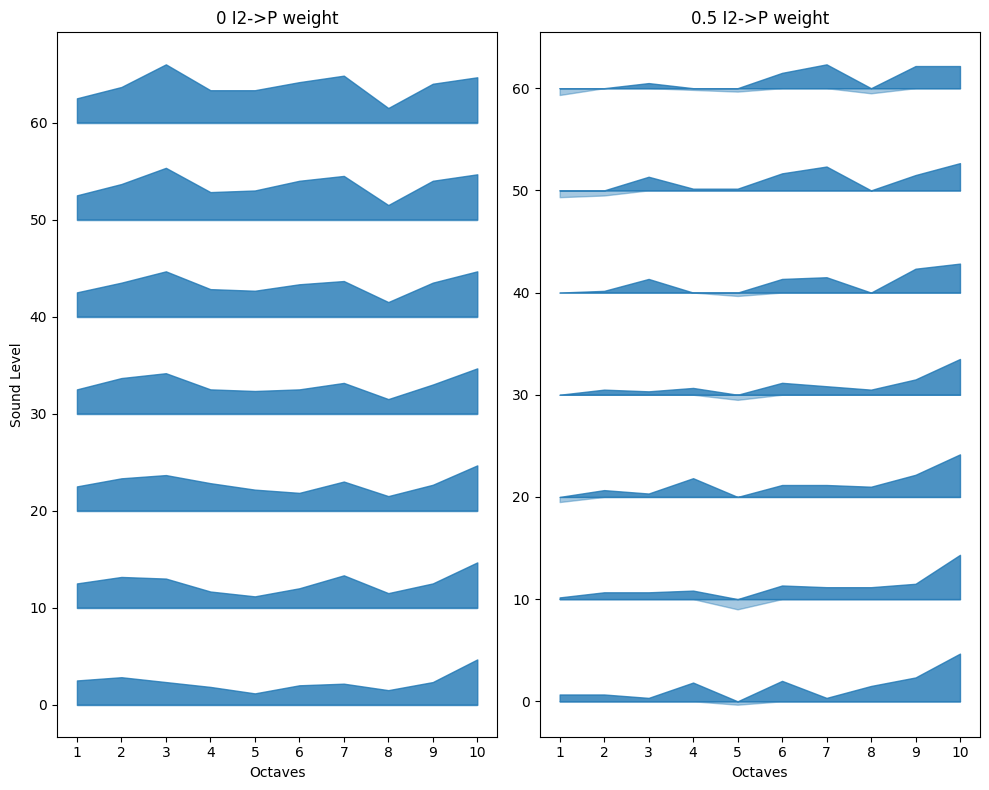

In [116]:
fig, axs = plt.subplots(1, len(i_weights), figsize=(10,8))

p_spon_freq = 36
scale = 6

for i, i_w in enumerate(i_weights):

    yticks = []

    for bf, col in num_spikes_df[i_w].items():
        # print(bf)
        # print(col.values)

        yticks.append(bf*scale)

        diff = col.values - p_spon_freq
        pos = diff.copy()
        pos[pos < 0] = 0
        neg = diff.copy()
        neg[neg > 0] = 0
        temp = 5

        octaves = [i for i in range(n_cells)]

        # axs[i].plot(col.values + bf*scale)
        # axs[i].plot([p_spon_freq + bf*scale for i in col.values])
        axs[i].fill_between(octaves, pos + bf*scale, [bf*scale for i in col.values], color='tab:blue', alpha=0.8)
        axs[i].fill_between(octaves, neg + bf*scale, [bf*scale for i in col.values], color='tab:blue', alpha=0.4)

    axs[i].set_title(f'{i_w} I2->P weight')
    axs[i].set_xticks([i for i in range(n_cells)])
    axs[i].set_xticklabels([i for i in range(1,n_cells+1)])
    axs[i].set_xlabel('Octaves')
    axs[i].set_yticks(yticks)
    axs[i].set_yticklabels(bfs)

axs[0].set_ylabel('Sound Level')

fig.tight_layout()

slides with results, connectivity schematic, and table of parameters